# Instalation

In [1]:
!pip install seqeval
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16165 sha256=7854474fe9963fe7bb639377ed0b260ca896cf5d4e24cf7f9a0a8af4f297769d
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00


In [2]:
import os
import evaluate
import wandb
import numpy as np 
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
from transformers import TrainingArguments
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import Trainer
from transformers import pipeline
from spacy.training.iob_utils import biluo_to_iob, doc_to_biluo_tags
from tqdm.autonotebook import tqdm
tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# EDA

### Load data

In [3]:
uk_location = pd.read_csv('/kaggle/input/nlp-ua-locations-extractions/uk_geo_dataset.csv', converters={"loc_markers": eval})
uk_location.sample(10)

,text,loc_markers,org_markers,per_markers,is_valid
446583,"На ньому накидка, що відбиває жовтими, голубим...",[],[],[],0
444110,"""Добре до нас ставилися, нічого не скажу.",[],[],[],0
818871,"Перш за все, медики радять часто і сумлінно ми...",[],[],[],0
900707,Ці персони стали фігурантами адміністративних ...,[],[],[],0
752025,У номері був присутній сильний запах алкоголю.,[],[],[],0
328679,Національний банк України встановив такі курси...,[],"[(13, 25)]",[],0
385940,Зараз в Атланті три номінальних центрових – но...,"[(8, 15)]",[],"[(52, 66), (68, 80), (83, 87)]",0
740365,"Вони бояться, що свої квартири можуть просто в...",[],[],[],0
216021,"Словом, Василь Червак був прийнятий на роботу,...",[],[],"[(8, 21)]",0
670852,"ТСН вирішила зібрати усі факти і свідчення, а ...",[],[],[],0


In [4]:
ru_location = pd.read_csv("/kaggle/input/nlp-ua-locations-extractions/ru_geo_dataset.csv", converters={'loc_markers': eval})
ru_location.sample(10)

,text,loc_markers,org_markers,per_markers,doc_id,sent_id
3161529,Вампирский слэшер Castlevania: Lords of Shadow...,[],"[(85, 97)]",[],270896,7
3095483,"Он был основан как почтовая станция, его назва...",[],[],[],265773,21
5428739,"В частности, именно этим они объясняют незначи...",[],[],[],460002,1
3108290,"Однако, по словам источника, принятых мер буде...",[],[],"[(106, 118)]",266765,5
7784817,"Газета ""Время Новостей"" пишет, что ликвидация ...","[(126, 132), (202, 209)]","[(8, 22), (46, 61), (235, 241)]",[],707784,9
1184589,"Лидер Радикальной партии Олег Ляшко заявил, чт...","[(63, 70)]","[(6, 24)]","[(25, 35)]",107086,0
1730392,"Вероятно, да!» — заявил Кадыров.",[],[],"[(24, 31)]",155224,18
1956944,"Члены ОПГ причастны к ряду убийств, в том числ...","[(69, 81)]","[(6, 9)]","[(82, 96), (99, 116), (167, 182), (210, 227)]",173278,11
3847364,Пресс-секретарь Российского союза туриндустрии...,[],"[(16, 46), (69, 80)]","[(47, 59)]",324502,9
1085278,Мы в Москве.,"[(5, 11)]",[],[],97867,3


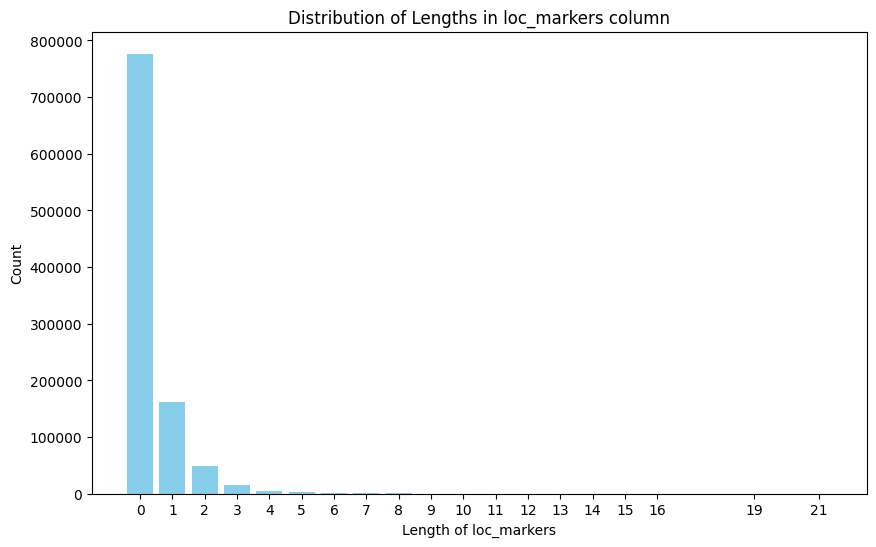

In [16]:
data = uk_location["loc_markers"].apply(len).value_counts()

x_values = data.index
y_values = data.values

plt.figure(figsize=(10, 6)) 
plt.bar(x_values, y_values, color='skyblue')
plt.xlabel('Length of loc_markers')
plt.ylabel('Count')
plt.title('Distribution of Lengths in loc_markers column')
plt.xticks(x_values) 
plt.show()

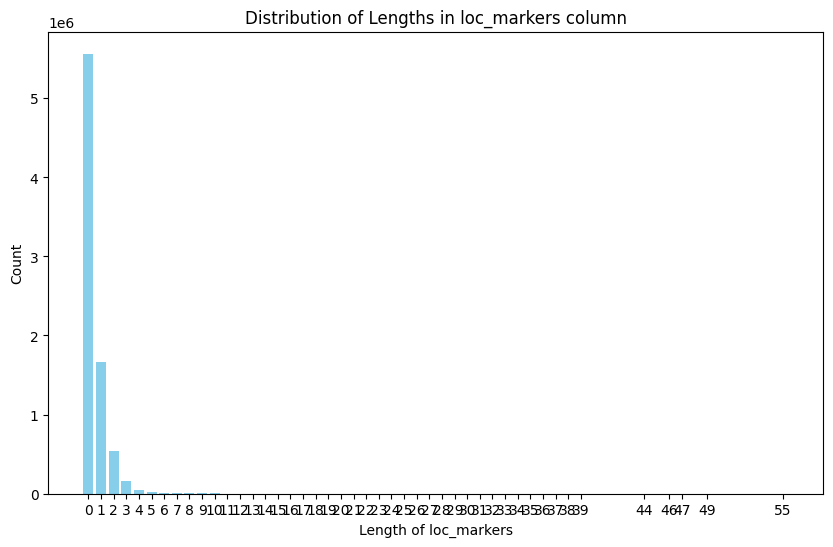

In [18]:
data = ru_location["loc_markers"].apply(len).value_counts()

x_values = data.index
y_values = data.values

plt.figure(figsize=(10, 6)) 
plt.bar(x_values, y_values, color='skyblue')
plt.xlabel('Length of loc_markers')
plt.ylabel('Count')
plt.title('Distribution of Lengths in loc_markers column')
plt.xticks(x_values)
plt.show()

## Data Preparation

shuffling

In [5]:
group_by_docs = ru_location.groupby('doc_id')

In [16]:
def merge_groups(group, text_only=True):
    group = group.sort_values(by=['sent_id']).reset_index(drop=True)
    if text_only:
        return ' '.join(group['text'])
    else:
        try:
            offset = 0
            new_locs = group.loc[0, 'loc_markers']
            for sentence, locs in zip(group['text'].tolist()[:-1], group['loc_markers'].tolist()[1:]):
                offset += len(sentence)
                for loc in locs:
                    new_locs.append((loc[0]+  offset, loc[1] + offset))
        except Exception:
            print(group)
        return {'text': ' '.join(group['text']), 'loc_markers': new_locs}

In [18]:
grouped_ru = group_by_docs.apply(merge_groups, text_only=False)
grouped_ru = pd.DataFrame({
    'text': [row['text'] for row in grouped_ru],
    'loc_markers': [row['loc_markers'] for row in grouped_ru]
})
grouped_ru

,text,loc_markers
0,Вице-премьер по социальным вопросам Татьяна Го...,"[(82, 88), (250, 259), (261, 269), (271, 279),..."
1,Австрийские правоохранительные органы не предс...,"[(0, 11), (147, 153), (156, 160), (580, 586), ..."
2,Сотрудники социальной сети Instagram проанализ...,"[(256, 266), (269, 274), (388, 399), (945, 953..."
3,С начала расследования российского вмешательст...,"[(65, 68), (182, 185), (450, 453), (662, 665),..."
4,Хакерская группировка Anonymous опубликовала н...,"[(382, 396), (505, 510), (551, 572), (636, 641..."
...,...,...
739185,Сегодня областной центр Сахалина и Курил получ...,"[(24, 32), (35, 40), (148, 167), (192, 207), (..."
739186,Выступая сегодня на пресс-конференции в Москве...,"[(40, 46)]"
739187,Сегодня утром в районах дагестанских селений Ч...,"[(45, 54), (57, 65), (228, 230), (233, 242), (..."
739188,Намеченная на сегодняшний день церемония вступ...,"[(146, 152), (311, 317), (363, 381), (447, 465..."


In [145]:
uk_location["language"] = "ukr"
grouped_ru_df["language"] = "rus"

geo_dataset = pd.concat([grouped_ru_df, uk_location]).reset_index(drop=True).sample(frac = 1)

In [146]:
df_valid = geo_dataset[geo_dataset.is_valid.astype(bool)].sample(frac=0.1)
df_train = geo_dataset[~geo_dataset.is_valid.astype(bool)].sample(frac=0.05)
df_locations = pd.concat([df_train, df_valid])
 
df_locations['loc_markers'] = df_locations['loc_markers'].apply(lambda x: [[y[0], y[1], 'LOC']  for y in eval(str(x))])

nlp = spacy.blank("xx")

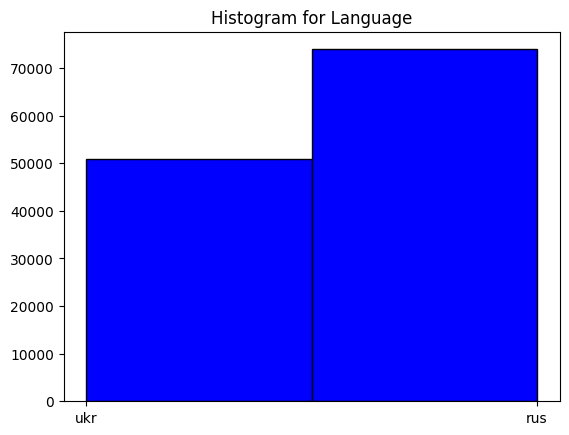

In [147]:
plt.hist(df_locations['language'], bins=2, color='blue', edgecolor='black')  
plt.title('Histogram for Language') 
plt.show()

In [148]:

def convert_to_conll(row):
    data = {
        "text": row['text'],
        "label": row['loc_markers']
    }
    doc = nlp(data["text"])
    ents = []
    for start, end, label in data["label"]:
        span = doc.char_span(start, end, label=label)
        if span is not None:
            ents.append(span)
        else:
            
            #this is not ideal solution, for example it find out just 'площі' instead of 'площі Конституції' - but it make better our solutions at times.
            #in my opinion, this is not crucial, because we have little examples but we have decrease of computions
            for i in range(0, end):
                adjusted_end = start + i
                adjusted_span = doc.char_span(start, adjusted_end, label=label)
                if adjusted_span is not None:
                    ents.append(adjusted_span)
                    start = adjusted_end
                    break
                else:
                    pass
    doc.ents = ents
    return {
        'tokens': list([t.text for t in doc]),
        'labels': list(biluo_to_iob(doc_to_biluo_tags(doc)))
    }

df_locations['conll'] = df_locations[['text', 'loc_markers']].progress_apply(convert_to_conll, axis=1)

  0%|          | 0/124919 [00:00<?, ?it/s]

In [150]:
label2id = {'O': 0, 'B-LOC': 1, 'I-LOC': 2}

df_locations['tokens'] = df_locations.conll.str['tokens']
df_locations['ner_tags'] = df_locations.conll.str['labels'].apply(lambda x: [label2id[t] for t in x])

df_train = df_locations[df_locations.is_valid == 0]
df_valid = df_locations[df_locations.is_valid == 1]

In [151]:
df_train[['tokens', 'ner_tags']].to_json(
    '/kaggle/working/train_processed.json', orient='records', lines=True)
df_valid[['tokens', 'ner_tags']].to_json(
    '/kaggle/working/valid_processed.json', orient='records', lines=True)

In [152]:
raw_datasets_ua = load_dataset(
    "json",
    data_files={
        'train': '/kaggle/working/train_processed.json',
        'val': '/kaggle/working/valid_processed.json'
    }
)
raw_datasets_ua

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-9a0ecfc20984d3ff/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 50000
    })
    val: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 989
    })
})

In [153]:
id2label = {v: k for k, v in label2id.items()}

model = AutoModelForTokenClassification.from_pretrained(
    'microsoft/mdeberta-v3-base',
    id2label=id2label,
    label2id=label2id,
)
tokenizer = AutoTokenizer.from_pretrained('microsoft/mdeberta-v3-base')

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [157]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)


def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [158]:
tokenized_datasets_ua = raw_datasets_ua.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets_ua["train"].column_names,
)

  0%|          | 0/50 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

# Hyperparameters

**I tried testing the model with different models, batch sizes, learning rates. Training for submission was with 3 epochs, that was enough. Also, training was done with 10 percent of the initial dataset, due to the fact that the training time is very large.
Models: Multilingual Deberta performed best, with a F1 result of 0.911 using already optimized learning speed and batch sizes. Roberta gave the result - 0.86, Bert - 0.87. The best batch size is 32. The best learning rate is 1e-4 and 1e-2, further increase will decrease the accuracy. All the time, there was a correlation between the validation results and the LB results, which is a very good result. The absolute difference is due to the fact that maybe the data is different on validation and on LB, it is also possible that the model is overfited or tokenization was performed incorrectly.**

**the latest training results**

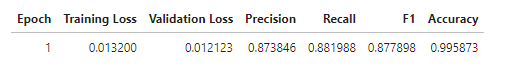

**As we can see, the accuracy of the model decreased when the dataset with the russian language was used for training, and this is easily explained - the test file, for which predictions are made, does not contain texts in кussian, because of this, training in Russian does not make much sense. Perhaps in the private test file, the russian language is more significant in percentage terms**

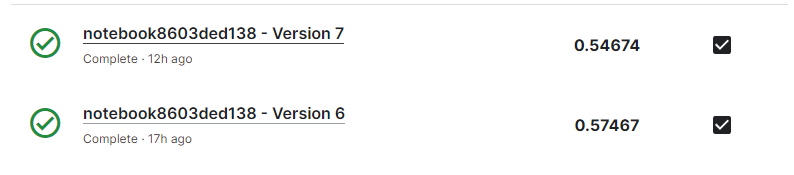

In [159]:
args = TrainingArguments(
    "bert-ua-loc-ner",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=1
)

In [160]:
model

DebertaV2ForTokenClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(251000, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=Tr

In [161]:
optimizer = AdamW([
    {'params': list(model.deberta.parameters()), 'lr': 1e-4},
    {'params': list(model.classifier.parameters()), 'lr': 1e-2}
])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0.1*1*(tokenized_datasets_ua['train'].num_rows/32),
    num_training_steps=1*(tokenized_datasets_ua['train'].num_rows/32)
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [162]:
metric = evaluate.load("seqeval")

label_names = list(label2id.keys())

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [163]:
wandb.login(key='934dbc7b1d006602c7749e73cff768f43d4b010b')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [164]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets_ua["train"],
    eval_dataset=tokenized_datasets_ua["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    optimizers=(optimizer, scheduler)
)
trainer.train()

wandb: Currently logged in as: danielreznik45. Use `wandb login --relogin` to force relogin


You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.013200,0.012123,0.873846,0.881988,0.877898,0.995873


TrainOutput(global_step=1563, training_loss=0.030278990952082346, metrics={'train_runtime': 626.0918, 'train_samples_per_second': 79.86, 'train_steps_per_second': 2.496, 'total_flos': 2007499396079232.0, 'train_loss': 0.030278990952082346, 'epoch': 1.0})

In [165]:
model_checkpoint = "./bert-ua-loc-ner/checkpoint-1563/"
token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)

**I had to finish it, but i don't have enough time.**

In [ ]:
'''def count_location(labels):
    locations = [1 for label in labels if label == 'B-LOC']
    return len(locations)'''

In [ ]:
'''df_train["number_of_locations"] = df_train["loc_markers"].apply(len)
df_train['stratify_col'] = df_train['number_of_locations']
df_train.loc[df_train['number_of_locations'] >= 12, 'stratify_col'] = -1
skf = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)
cv_train_test = [fold for fold in skf.split(df_train, df_train['stratify_col'])]'''

In [ ]:
'''def cv_function(max_epoch_number, train_dataset, folds):

    epoch_fold_losses = [[] for _ in range(max_epoch_number)]
    epoch_fold_precision = [[] for _ in range(max_epoch_number)]
    epoch_fold_recall = [[] for _ in range(max_epoch_number)]
    epoch_fold_auc = [[] for _ in range(max_epoch_number)]
    epoch_train_score = [[] for _ in range(max_epoch_number)]
    epoch_test_score = [[] for _ in range(max_epoch_number)]
    
    optimizer = AdamW([
    {'params': list(model.deberta.parameters()), 'lr': 1e-4},
    {'params': list(model.classifier.parameters()), 'lr': 1e-2}
    ])

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0.1*3*(tokenized_datasets_ua['train'].num_rows/32),
        num_training_steps=3*(tokenized_datasets_ua['train'].num_rows/32)
    )
    
    for fold_i, fold in enumerate(folds):
        print(f'Fold {fold_i+1}:')
        train_ids, test_ids = fold
        df_train = df_train.iloc[train_ids]
        df_valid = df_valid.iloc[test_ids]
        
        df_train[['tokens', 'ner_tags']].to_json(
            '/kaggle/working/train_processed.json', orient='records', lines=True)
        df_valid[['tokens', 'ner_tags']].to_json(
            '../data/nlp-ua-locations-extractions/valid_processed.json', orient='records', lines=True)
        
        raw_datasets_ua = load_dataset("json", data_files={'train': '/kaggle/working/train_processed.json',
            'val': '../data/nlp-ua-locations-extractions/valid_processed.json'})
        
        
        model = AutoModelForTokenClassification.from_pretrained(
            'microsoft/mdeberta-v3-base',
            id2label=id2label,
            label2id=label2id,
        )
        tokenizer = AutoTokenizer.from_pretrained('microsoft/mdeberta-v3-base')

        tokenized_datasets_ua = raw_datasets_ua.map(
            tokenize_and_align_labels,
            batched=True,
            remove_columns=raw_datasets_ua["train"].column_names,
        )
        
        args = TrainingArguments(
            "bert-ua-loc-ner",
            per_device_train_batch_size=32,
            per_device_eval_batch_size=32,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            num_train_epochs=3
        )
        
        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=tokenized_datasets_ua["train"],
            eval_dataset=tokenized_datasets_ua["val"],
            data_collator=data_collator,
            compute_metrics=compute_metrics,
            tokenizer=tokenizer,
            optimizers=(optimizer, scheduler)
        )
        trainer.train()

    return None'''

In [171]:
competition_test = pd.read_csv('/kaggle/input/nlp-ua-locations-extractions/test.csv', converters = {'locations': eval})
labeling_sample = pd.read_csv('/kaggle/input/nlp-ua-locations-extractions/labeling_sample.csv', converters = {'locations': eval})

In [174]:
data = token_classifier(competition_test.loc[2].text)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [175]:
words = [item['word'] for item in data]
words

['Гоголеве', 'Миргородського району', 'Полтавської області']

In [ ]:
for i, row in competition_test.iterrows():
    text = row['text']
    data = token_classifier(text)
    words = [item['word'] for item in data]
    competition_test.at[i, 'locations'] = words

print(competition_test)

In [ ]:
competition_test[['text_id', 'locations']].to_csv('submission.csv', index=False)

In [ ]:
competition_test